In [27]:
from google.cloud import bigquery
from google.oauth2 import service_account

import pandas as pd
import numpy as np
import math

from sklearn.model_selection import train_test_split

from scipy import stats
from dython.nominal import associations

import seaborn as sns
import matplotlib.pyplot  as plt

In [28]:
train_name='train_incident'
validation_name='validation_incident'
test_name='test_incident'

In [29]:
# projectId='pongthorn'
projectId='smart-data-ml'
dataset_dw_id='SMartDW'
dataset_id='SMartML'

dw_table_id = f"{projectId}.{dataset_dw_id}.incident"

train_table_id=f"{projectId}.{dataset_id}.{train_name}"
val_tabel_id=f"{projectId}.{dataset_id}.{validation_name}"
test_tabel_id=f"{projectId}.{dataset_id}.{test_name}"

file_name="ML_Incident.csv"

credentials = service_account.Credentials.from_service_account_file(r'C:\Windows\smart-data-ml-91b6f6204773.json')
client = bigquery.Client(credentials=credentials, project=projectId)

# client = bigquery.Client(project=projectId)

In [30]:
isLastUpdate=True

IsNewData=False

label='severity_id'
labelName='severity_name'

threshold_x_sd = 3  # 2.5/3/3.5


removeCols=['id','updated_at','imported_at']

dateCols=['open_datetime','close_datetime','response_datetime','resolved_datetime']

numbericCols=['count_detail','open_to_close_hour','open_to_response_hour','response_to_resolved_hour']
#numbericCols=['count_detail','open_to_close_hour']

cateCols=['sla','product_type','brand','service_type','incident_type']


# Explore and Transform Data

In [31]:
def load_data_bq(sql:str):

 query_result=client.query(sql)
 df_all=query_result.to_dataframe()
 return df_all


In [32]:
imported_to='2023-07-16'  # for test  date+1 of the day that you perform
#imported_to='2023-03-13' For production
#updated_to='2023-03-13' # For test

sql_all=f"""
SELECT  id,severity_id,severity_name
,count_detail
,sla,product_type,brand,service_type,incident_type
,open_datetime,  close_datetime, response_datetime,resolved_datetime
,updated_at,imported_at

FROM `{dw_table_id}`    

WHERE imported_at< '{imported_to}'

order  by imported_at
"""
#WHERE updated_at< '{updated_to}'
#WHERE imported_at< '{imported_to}'

# copy sql statement to check whether to be valid or not
print(sql_all)


SELECT  id,severity_id,severity_name
,count_detail
,sla,product_type,brand,service_type,incident_type
,open_datetime,  close_datetime, response_datetime,resolved_datetime
,updated_at,imported_at

FROM `smart-data-ml.SMartDW.incident`    

WHERE imported_at< '2023-07-16'

order  by imported_at



In [33]:
print("Load data from Bigquery")
df_all=load_data_bq(sql_all)
if len(df_all)==0:
 print("No records from bigquery")  
 quit()
else:
 print(df_all.shape)   

Load data from Bigquery
(2981, 15)


In [34]:
df_all=df_all.drop_duplicates(subset=['id'],keep='last')

no_original_rows=len(df_all)

df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2981 entries, 0 to 2980
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 2981 non-null   Int64         
 1   severity_id        2981 non-null   Int64         
 2   severity_name      2981 non-null   object        
 3   count_detail       2981 non-null   Int64         
 4   sla                2981 non-null   object        
 5   product_type       2981 non-null   object        
 6   brand              2981 non-null   object        
 7   service_type       2981 non-null   object        
 8   incident_type      2981 non-null   object        
 9   open_datetime      2981 non-null   datetime64[ns]
 10  close_datetime     2981 non-null   datetime64[ns]
 11  response_datetime  2981 non-null   datetime64[ns]
 12  resolved_datetime  2981 non-null   datetime64[ns]
 13  updated_at         2981 non-null   datetime64[ns]
 14  imported

# Manage Numberic Cols
Converting the data of these columns to hourly time period., it is more informative


In [35]:
start_end_list=[ ['open_datetime','close_datetime'],['open_datetime','response_datetime'],['response_datetime','resolved_datetime']]
listDiffDateDeltaCols=[]
listDiffHourCols=[]
for item  in  start_end_list:
   diff_str=f"{item[0]}_to_{item[1]}" 
   diff_str=diff_str.replace('_datetime','')  
   listDiffDateDeltaCols.append(diff_str)
   df_all[diff_str]=df_all[item[1]]-df_all[item[0]]
    
   diff_hour=f'{diff_str}_hour'
   listDiffHourCols.append(diff_hour)
   df_all[diff_hour] = df_all[diff_str].apply(lambda x:  x.total_seconds() / (60*60) if x is not np.nan else np.nan  )


#df_all[listDiffHourCols].describe()
df_all[listDiffHourCols].describe(percentiles=[.95,.75,.50,.25,.05])

,open_to_close_hour,open_to_response_hour,response_to_resolved_hour
count,2981.000000,2981.000000,2981.000000
mean,193.887012,3.494694,150.471279
std,800.929540,35.761435,746.426981
min,0.000000,0.000000,0.000000
5%,0.800000,0.000000,0.000000
25%,4.033333,0.033333,2.000000
50%,9.550000,0.150000,6.500000
75%,53.966667,0.500000,28.833333
95%,957.100000,7.000000,607.016667
max,13177.250000,1152.133333,13176.250000


# Remove outlier on Time Interval to service

In [36]:
# https://www.geeksforgeeks.org/z-score-for-outlier-detection-python/
xScoreDiffHourCols=[]
for col in listDiffHourCols:
  z_col=f"zscore_{col}"   
  df_all[z_col] = np.abs(stats.zscore(df_all[col]))   
  xScoreDiffHourCols.append(z_col)  
#remove oulier

for col in  xScoreDiffHourCols:
  df_all=df_all.query(f"{col}<@threshold_x_sd")


no_rows_after_removing_outlier=len(df_all)
pct_row_decrease=round( (no_original_rows-no_rows_after_removing_outlier)/no_original_rows*100 ,0)

print(f"% remove data {pct_row_decrease}")

print(df_all.info())

% remove data 2.0
<class 'pandas.core.frame.DataFrame'>
Index: 2922 entries, 0 to 2980
Data columns (total 24 columns):
 #   Column                            Non-Null Count  Dtype          
---  ------                            --------------  -----          
 0   id                                2922 non-null   Int64          
 1   severity_id                       2922 non-null   Int64          
 2   severity_name                     2922 non-null   object         
 3   count_detail                      2922 non-null   Int64          
 4   sla                               2922 non-null   object         
 5   product_type                      2922 non-null   object         
 6   brand                             2922 non-null   object         
 7   service_type                      2922 non-null   object         
 8   incident_type                     2922 non-null   object         
 9   open_datetime                     2922 non-null   datetime64[ns] 
 10  close_datetime         

# Find any rows  contain zero time period
## it doesn't make any sense on real world 

In [37]:
# if>5%  remove column, else judge to remove 0 value 
# remove coundetail because mostly, there are few value 1,2 items
allRows=df_all.shape[0]
for col in numbericCols:
    zeroRows=len(df_all.query(f"{col}==0"))
    pctZeroHour=round(zeroRows/allRows*100,1)
    print(f"No. 0-hour row on {col} = {zeroRows}({pctZeroHour} %)")
    
  # open_to_response_hour =o is not realistic  ==> move columns  
# No. 0-hour row on open_to_response_hour = 456(19.2 %) , it is relevant to site manage's behaviod
# They get incident call from customer  and provide engineer to response completely
# afte that they will enter the application to record case 

No. 0-hour row on count_detail = 117(4.0 %)
No. 0-hour row on open_to_close_hour = 1(0.0 %)
No. 0-hour row on open_to_response_hour = 572(19.6 %)
No. 0-hour row on response_to_resolved_hour = 149(5.1 %)


# Bining Range

function is used to separate the array elements into many different ranges . 
The cut function is mainly used to perform statistical analysis on scalar data. 

In [38]:
# https://www.geeksforgeeks.org/pandas-cut-method-in-python/


def explore_ranges_numberic_val(col,rangeList):
    print(col)
    rangeList.sort()
    return pd.cut(df_all[col],rangeList, right=True).value_counts()
range1= [0,24, 168, 360, 720,math.floor(df_all['open_to_close_hour'].max())]
print(explore_ranges_numberic_val('open_to_close_hour',range1))
print("=======================================================")

range2= [0,24, 168, 360, 720,math.floor(df_all['response_to_resolved_hour'].max())]
print(explore_ranges_numberic_val('response_to_resolved_hour',range2))
print("=======================================================")

# range3= [0,4, 8, 12, 24,math.floor(df_all['open_to_response_hour'].max())]
# print(explore_ranges_numberic_val('open_to_response_hour',range3))
# print("=======================================================")

range4= [0,2, 4,math.floor(df_all['count_detail'].max())]
print(explore_ranges_numberic_val('count_detail',range4))
print("=======================================================")

# we can convert hour to range   
# (0, 24] =by 1 day =best
# (24, 168] =  1day -1 week  =good
# (168, 360]=  1week- 15 days(half a month) =fair
# (360, 720]= 15 dasy-1 month =bad
# (720, 2349]=1 month-1 Q =worst

# open_to_close_hour ,response_to_resolved_hour , mostly  we can complate by 1 day (0, 24]
# there are few cased that take long to close incident (360, 720]   15 day to  1month

open_to_close_hour
open_to_close_hour
(0, 24]        1903
(24, 168]       639
(168, 360]      155
(720, 2589]     135
(360, 720]       88
Name: count, dtype: int64
response_to_resolved_hour
response_to_resolved_hour
(0, 24]        1984
(24, 168]       508
(168, 360]      121
(720, 2367]      96
(360, 720]       63
Name: count, dtype: int64
count_detail
count_detail
(0, 2]     2212
(2, 4]      352
(4, 36]     241
Name: count, dtype: int64


In [39]:
#Anyway , We will have 2 columns left 
print("remove some cate featurs that have undeisred data")

# open_to_response_hour :No. 0-hour row on open_to_response_hour = 456(19.2 %)
# ount_detail  : 80%  (0, 2] =1790 You'll notice that most of the data is clustered in (0, 2] detail  only
numColsRemove=['open_to_response_hour','count_detail'] 
numbericCols=[x for x in numbericCols if x not in numColsRemove]   
numbericCols

remove some cate featurs that have undeisred data


['open_to_close_hour', 'response_to_resolved_hour']

In [40]:
# remove response_to_resolved_hour ,it doesn't make any sense
# No. 0-hour row on response_to_resolved_hour = 99(4.2 %)
df_all=df_all.query('response_to_resolved_hour!=0')
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2773 entries, 0 to 2980
Data columns (total 24 columns):
 #   Column                            Non-Null Count  Dtype          
---  ------                            --------------  -----          
 0   id                                2773 non-null   Int64          
 1   severity_id                       2773 non-null   Int64          
 2   severity_name                     2773 non-null   object         
 3   count_detail                      2773 non-null   Int64          
 4   sla                               2773 non-null   object         
 5   product_type                      2773 non-null   object         
 6   brand                             2773 non-null   object         
 7   service_type                      2773 non-null   object         
 8   incident_type                     2773 non-null   object         
 9   open_datetime                     2773 non-null   datetime64[ns] 
 10  close_datetime                    2773 no

# Drop unnessay columns

In [41]:
removeCols=removeCols+dateCols+xScoreDiffHourCols+listDiffDateDeltaCols+numColsRemove
df_all=df_all.drop(columns=removeCols)
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2773 entries, 0 to 2980
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   severity_id                2773 non-null   Int64  
 1   severity_name              2773 non-null   object 
 2   sla                        2773 non-null   object 
 3   product_type               2773 non-null   object 
 4   brand                      2773 non-null   object 
 5   service_type               2773 non-null   object 
 6   incident_type              2773 non-null   object 
 7   open_to_close_hour         2773 non-null   float64
 8   response_to_resolved_hour  2773 non-null   float64
dtypes: Int64(1), float64(2), object(6)
memory usage: 219.3+ KB


In [42]:
df_all[numbericCols].describe(percentiles=[.95,.75,.50,.25,.05])
# 95% vs max

,open_to_close_hour,response_to_resolved_hour
count,2773.000000,2773.000000
mean,111.901947,85.774805
std,306.749149,267.224971
min,0.083333,0.016667
5%,0.833333,0.500000
25%,4.050000,2.983333
50%,9.250000,7.000000
75%,51.000000,29.583333
95%,676.620000,474.883333
max,2589.833333,2367.633333


# Plot Numeric  columns

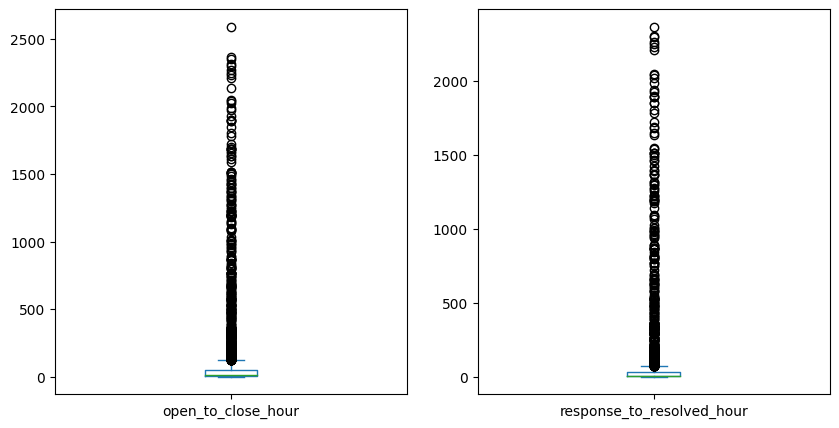

In [43]:
df_all[numbericCols].plot(kind='box',subplots=True,layout=(1,len(numbericCols)),sharex=False, sharey=False,figsize=(10,5))
plt.show()

array([[<Axes: xlabel='open_to_close_hour', ylabel='open_to_close_hour'>,
        <Axes: xlabel='response_to_resolved_hour', ylabel='open_to_close_hour'>],
       [<Axes: xlabel='open_to_close_hour', ylabel='response_to_resolved_hour'>,
        <Axes: xlabel='response_to_resolved_hour', ylabel='response_to_resolved_hour'>]],
      dtype=object)

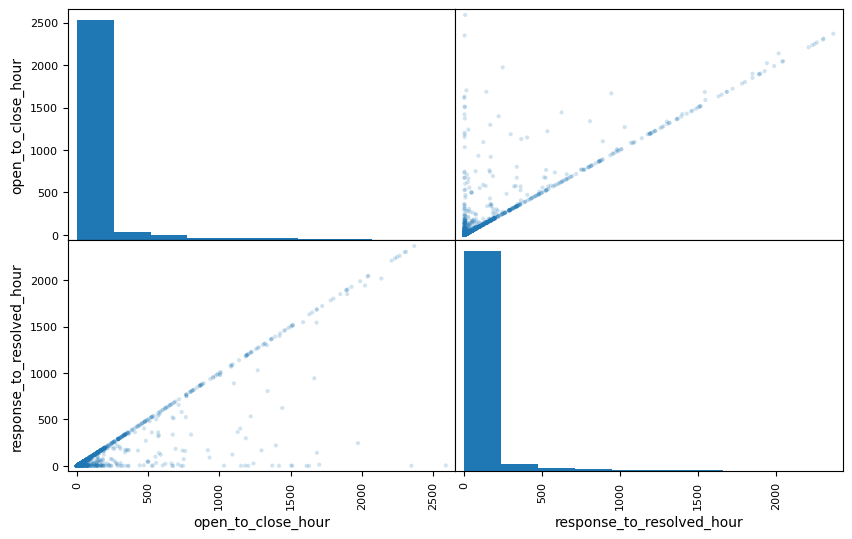

In [44]:
pd.plotting.scatter_matrix(df_all[numbericCols], alpha=0.2,figsize=(10,6))

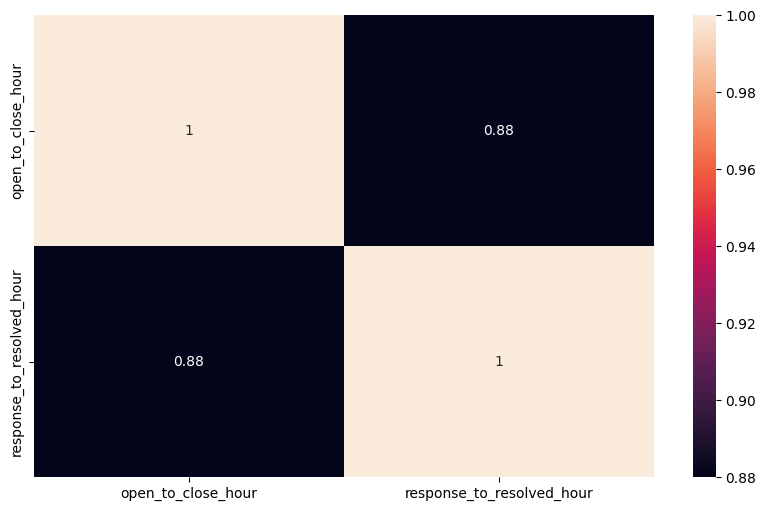

In [45]:
corr_df = df_all[numbericCols].corr ()  
corr_df = corr_df .round(2)

fig = plt.figure(figsize = (10, 6))
heatmap = sns. heatmap(corr_df, annot = True) 
plt. show ()

# Plot Categorical Cols

In [46]:
VBar=['brand','incident_type']
HBar=[ x for x in cateCols if x not in VBar]
HBar.insert(0,'severity_name')

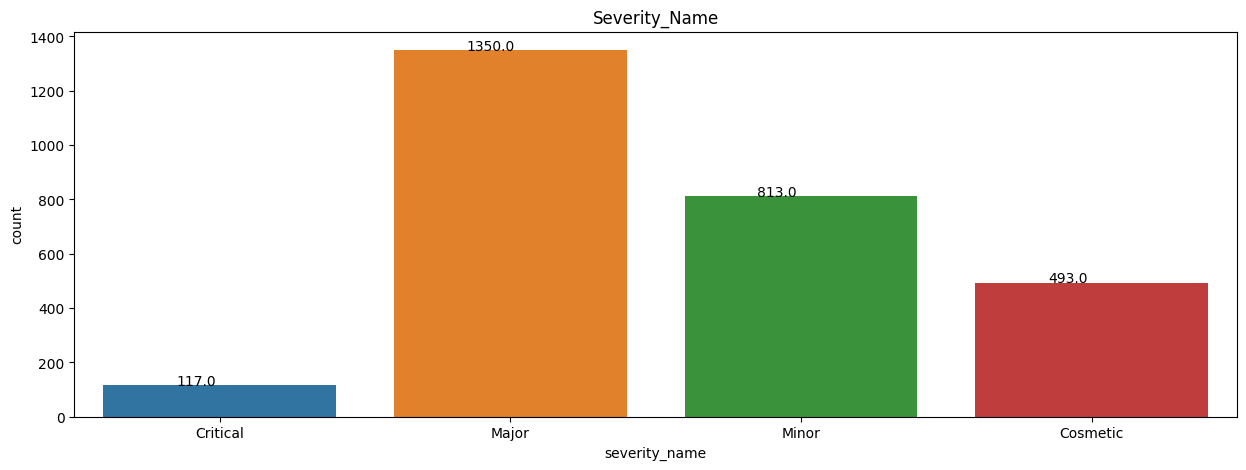

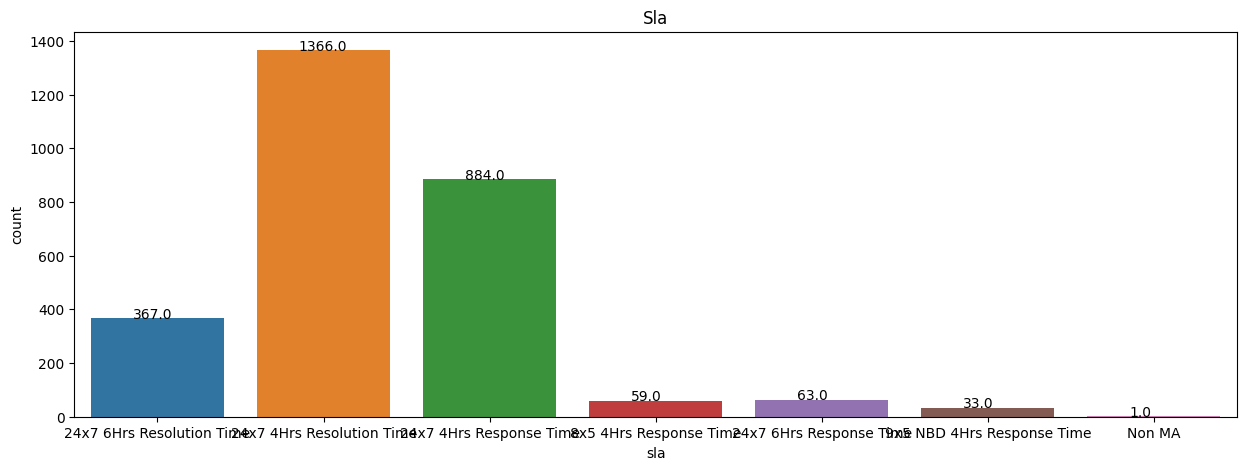

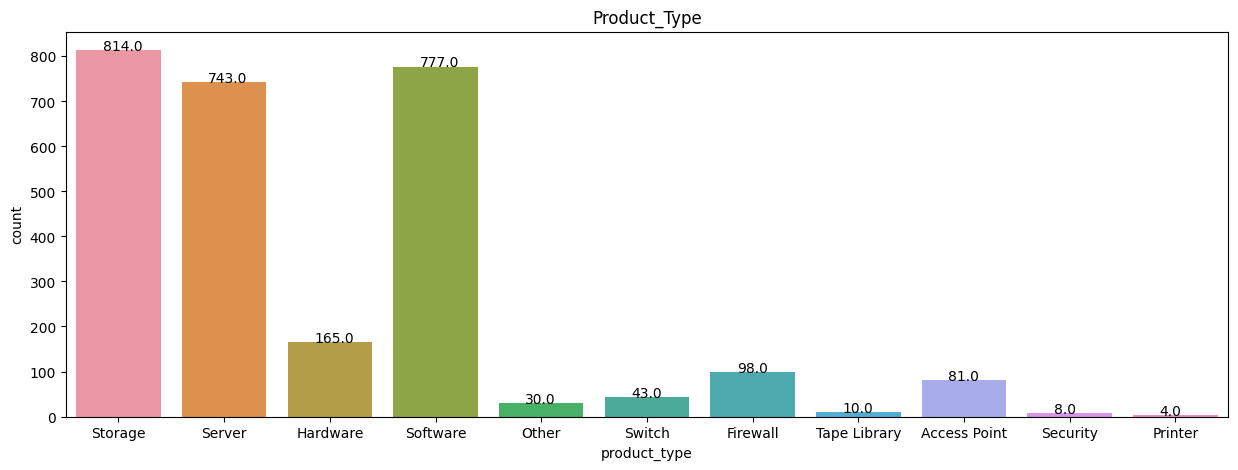

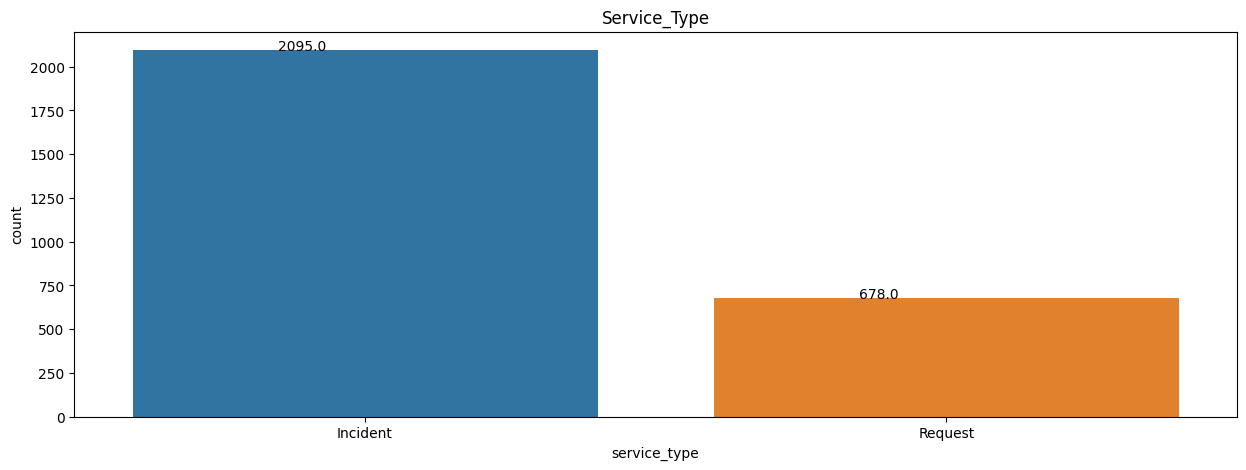

In [47]:
for col in HBar:
    fig , ax = plt.subplots(figsize=(15,5))
    ax =sns.countplot(x=col, data=df_all,)
    for p in ax.patches:
       ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))
    plt.title(col.title())
    plt.show()

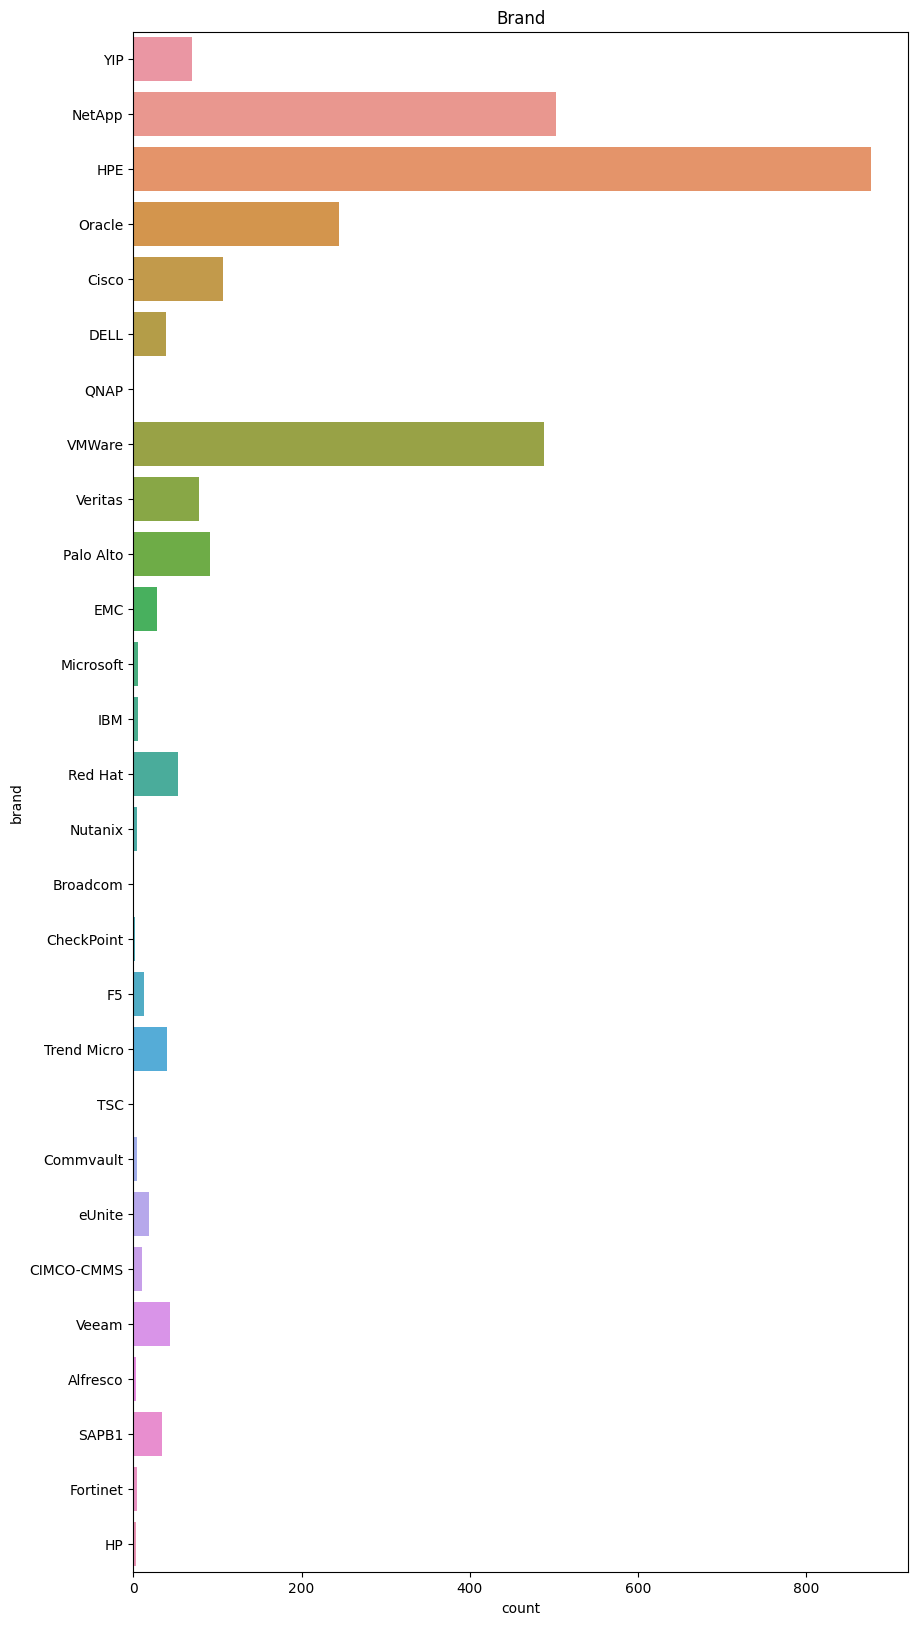

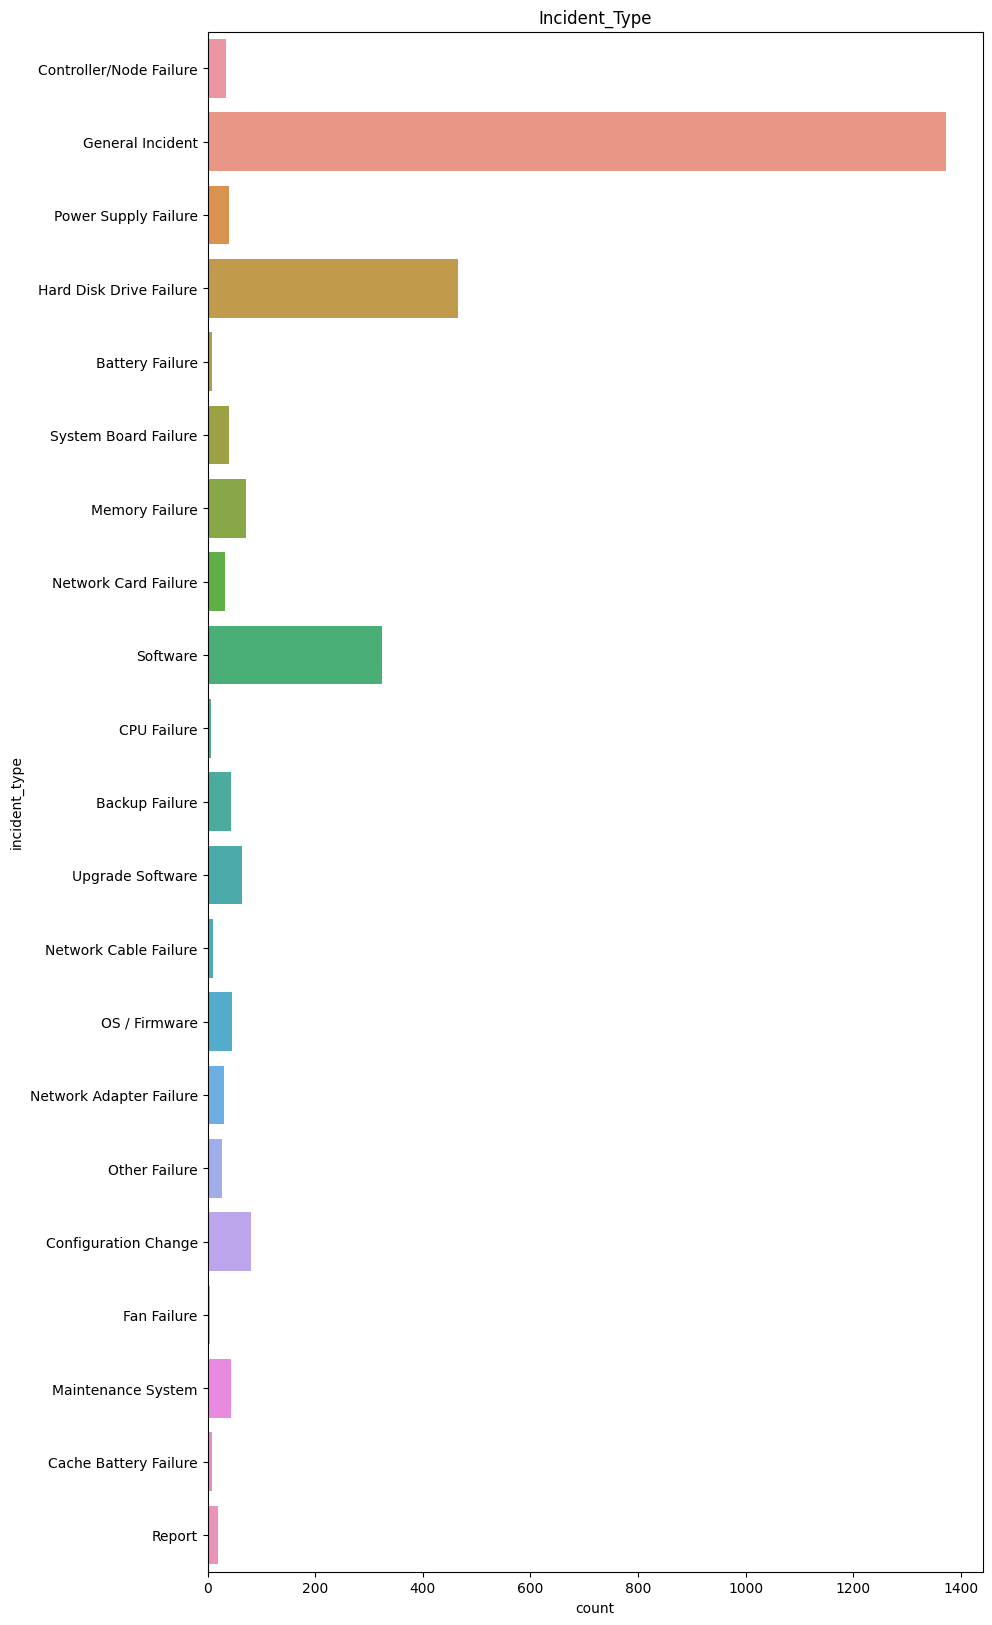

In [48]:
for col in VBar:
    fig , ax = plt.subplots(figsize=(10,20))
    ax =sns.countplot(y=col, data=df_all)
    plt.title(col.title())
    plt.show()

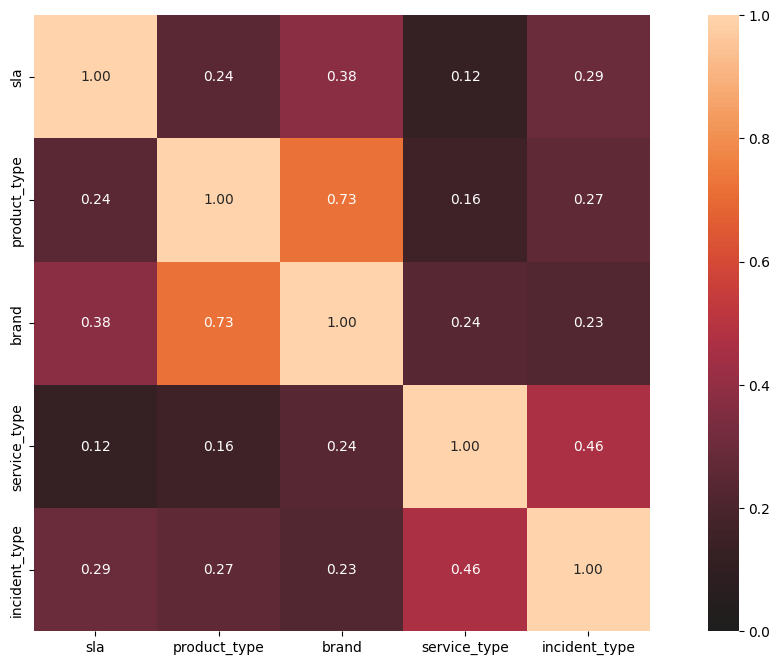

In [49]:
# all of them are not hardly relevant, it is hight variance
complete_correlation= associations(df_all[ cateCols ], figsize=(15,8))

In [51]:
print(df_all.info())
df_all.to_csv(f"data/{file_name}",index=False)
#bucket_name="gs://smart-ml-pongthorn"
# df_all.to_csv(f"{bucket_name}/{file_name}",index=False) 

<class 'pandas.core.frame.DataFrame'>
Index: 2773 entries, 0 to 2980
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   severity_id                2773 non-null   Int64  
 1   severity_name              2773 non-null   object 
 2   sla                        2773 non-null   object 
 3   product_type               2773 non-null   object 
 4   brand                      2773 non-null   object 
 5   service_type               2773 non-null   object 
 6   incident_type              2773 non-null   object 
 7   open_to_close_hour         2773 non-null   float64
 8   response_to_resolved_hour  2773 non-null   float64
dtypes: Int64(1), float64(2), object(6)
memory usage: 219.3+ KB
None


# Build Training DataSet

In [52]:
# create label
map_severity_to_class={'Cosmetic':0,'Minor': 1, "Major": 2, "Critical": 3}
print(f"Map severity Name to LabelCode: {str(map_severity_to_class)}")

Map severity Name to LabelCode: {'Cosmetic': 0, 'Minor': 1, 'Major': 2, 'Critical': 3}


In [53]:
df_all['label_multi_severity'] =df_all['severity_name'].map(map_severity_to_class) 
def map_4to2_serverity(severity_id):
    if severity_id==1 or severity_id==2:
       return 1
    else:
       return 0 
df_all['label_binary_severity'] =df_all['severity_id'].apply(map_4to2_serverity)

print( list(df_all['label_multi_severity'].unique()))
print(df_all['label_binary_severity'].unique())
df_all.head()

[3, 2, 1, 0]
[1 0]


,severity_id,severity_name,sla,product_type,brand,service_type,incident_type,open_to_close_hour,response_to_resolved_hour,label_multi_severity,label_binary_severity
0,1,Critical,24x7 6Hrs Resolution Time,Storage,YIP,Incident,Controller/Node Failure,23.183333,1.333333,3,1
1,1,Critical,24x7 4Hrs Resolution Time,Storage,NetApp,Incident,General Incident,10.500000,7.500000,3,1
2,1,Critical,24x7 4Hrs Resolution Time,Storage,NetApp,Incident,Controller/Node Failure,7.500000,7.500000,3,1
3,1,Critical,24x7 6Hrs Resolution Time,Storage,NetApp,Incident,Power Supply Failure,88.183333,86.533333,3,1
4,1,Critical,24x7 4Hrs Resolution Time,Storage,NetApp,Incident,Hard Disk Drive Failure,8.783333,8.683333,3,1


In [54]:
#Split data into 3 dataset to BQ
len_all=len(df_all)
print(f"All Data = {len_all}")

# Split the 80% of total as train
# The remaining  will be splited equally 50% for valuation and the rest of later part is test

train, val = train_test_split(df_all,test_size=0.2,random_state=1000,shuffle=True)
val,test = train_test_split(val, test_size=0.5,random_state=1000,shuffle=True)

len_all=len(df_all)
len_train=len(train)
len_val=len(val)
len_test=len(test)
print(f'{len_train} =train examples ({round(len_train/len_all*100,1)}%)')
print(f'{len_val} =val examples ({round(len_val/len_all*100,1)}%)')
print(f'{len_test} =test examples ({round(len_test/len_all*100,1)}%)')

All Data = 2773
2218 =train examples (80.0%)
277 =val examples (10.0%)
278 =test examples (10.0%)


In [55]:
print(f"pct removed data ={(no_original_rows-len(df_all))/no_original_rows*100}")
#it is pretty close to 5%   , at most 10% is removable

pct removed data =6.977524320697752


In [56]:
def loadDataFrameToBQ(table_id,dfx):
    try:
        job_config = bigquery.LoadJobConfig(
            write_disposition="WRITE_TRUNCATE",
        )

        job = client.load_table_from_dataframe(
            dfx, table_id, job_config=job_config
        )
        job.result()  # Wait for the job to complete.
        print(f"{len(dfx)} rows imported to {table_id} successfully")

    except BadRequest as e:
        print("Bigquery Error\n")
        for e in job.errors:
            print('ERROR: {}'.format(e['message']))
            
# save to csv file to load faster than bigquery
train.to_csv(f"data/{train_name}.csv",index=False)
val.to_csv(f"data/{validation_name}.csv",index=False)
test.to_csv(f"data/{test_name}.csv",index=False)

#write_disposition="WRITE_TRUNCATE"
#google will create table and load data into them automaticall 
loadDataFrameToBQ(f"{train_table_id}",train)
loadDataFrameToBQ(f"{val_tabel_id}",val)
loadDataFrameToBQ(f"{test_tabel_id}",test)   
    

2218 rows imported to smart-data-ml.SMartML.train_incident successfully
277 rows imported to smart-data-ml.SMartML.validation_incident successfully
278 rows imported to smart-data-ml.SMartML.test_incident successfully
